Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "avsemenyuk"
COLLABORATORS = ""

---

# Метод наименьших квадратов (линейный случай).

Рассмотрим функцию $y = f(x)$ определенной набором значений $y_0, y_1, \cdots, y_n$ в точках $x_0, x_1, \cdots, x_n$.

In [2]:
import numpy as np

x = np.asarray([-1, -0.7, -0.43, -0.14, 0.14, 0.43, 0.71, 1, 1.29, 1.57, 1.86, 2.14, 2.43, 2.71, 3])
y = np.asarray([-2.25, -0.77, 0.21, 0.44, 0.64, 0.03, -0.22, -0.84, -1.2, -1.03, -0.37, 0.61, 2.67, 5.04, 8.90])

rng = np.random.default_rng(123)
x += 0.1 * rng.uniform(size=len(x))
y += 4 * rng.uniform(size=len(x))

### I. Найдите многочлен наилучшего приближения,

$$
P_m(x) = a_0 + a_1 x + \cdots + a_m x^m
$$

используя линейный метод наименьших квадратов.Для этого:

1. реализуйте алгоритм, создающий  "design matrix" `А`, используя $1, x, \cdots, x^m$ в качестве базисных функций.

2. постройте явно нормальную систему уравнений задачи наименьших квадратов при фиксированных значениях $m$.

3. решите систему уравнений, чтобы найти коэффициенты $P_m(x)$ для $m = 0, 1, 2, \dots$. Для решения задач линейной алгебры можете использовать либо библиотечные функции (`numpy.linalg.solve`), либо Вашу реализацию LU - разложение из 1 недели.

---
`Linear Least Squares problem:`
$$\xi(\beta) = \sum_{j=1}^n |y_j - P(x_j, \beta)|^2 \rightarrow min, \ \ \text{where} \ P(x, \beta) = \sum_{j=1}^m \beta_k \varphi_k(x)$$

`Equivalent to`
$$\xi(\beta) = ||y - A\beta||_2^2 \rightarrow min,$$
$\text{where} \ A_m = [\varphi_1(x) \ \varphi_2(x) \ \cdots \ \varphi_{m}(x)]- \text{design matrix.}$

`Normal equations method solution:`
$$A^T A \beta = A^T y$$

`Polinomial fitting:`
$$\varphi_k(x) = x^{k-1}, \ k=1,..,m$$

In [3]:
import numpy as np

def design_matrix(x, m):
    """Construct the design matrix with monomials x**k for k=0..m-1"""
    rows = len(x)
    cols = m
    
    A = np.ones((rows,cols), dtype=float)
    for col in range(1, cols):
        A[:,col] = [s**col for s in x]
    return A

In [4]:
assert design_matrix(x, 3).shape == (len(x), 3)
assert design_matrix(x, 11).shape == (len(x), 11)

In [5]:
def lsq_poly(x, y, m):
    """Construct the LSQ polynomial of degree `m-1`.
    
    Parameters
    ----------
    x : array_like
        Sample points
    y : array_like
        Measured values
    m : int
        The number of coefficients of the LSQ polynomial
        (i.e. the degree of the polynomial is `m-1`)
        
    Returns
    -------
    p : callable 
        np.polynomial.Polynomial instance, representing the LSQ polynomial
        
    Examples
    --------
    >>> p = lsq_poly([1, 2, 3], [4, 5, 6], m=2)
    >>> p(np.array([1.5, 2.5]))
    array([4.5, 5.5])
    
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if x.shape[0] != y.shape[0]:
        raise ValueError("Expect paired data.")
    if x.shape[0] <= m:
        raise ValueError("Cannot fit a degree-%s polynomial through %s points" % (m, x.shape[0]))
        
    A = design_matrix(x,m)
    coeffs = np.linalg.solve(A.T@A, A.T@y)[::-1]
    
    return np.poly1d(coeffs)

In [6]:
import pytest
with pytest.raises(ValueError):
    lsq_poly([1, 2, 3], [1, 2], m=1)

with pytest.raises(ValueError):
    lsq_poly([1, 2, 3], [1, 2, 3], m=3)
    
# test that lsq_poly returns a callable object
# which support vectorized evaluation
p = lsq_poly(x, y, m=3)
assert len(p(x)) == len(x)

Вычислите число обусловленности матрицы `A` и матрицы левой части системы нормальных уравнений в зависимости $m$, и напечатайте их на экран.
Прокомментируйте полученные результаты.

In [7]:
print(f'A norm \t\t (A^T)A norm')
for m in range(1, 10):
    A = design_matrix(x, m)
    print(f'{np.linalg.cond(A):.2e} \t {np.linalg.cond(A.T@A):.2e}')

A norm 		 (A^T)A norm
1.00e+00 	 1.00e+00
2.54e+00 	 6.47e+00
7.97e+00 	 6.36e+01
3.37e+01 	 1.13e+03
1.49e+02 	 2.23e+04
7.09e+02 	 5.03e+05
3.63e+03 	 1.32e+07
1.83e+04 	 3.37e+08
1.02e+05 	 1.05e+10


$cond(A^T A) = (cond(A))^2$

Отсюда можно сделать вывод о том, что нормальная система уравнений задачи наименьших квадратов обычно очень плохо обусловлена.

In [8]:
# This cell is a test: keep it intact


### II. Многочлен наилучшего приближения.

Ясно, что бесконтрольно увеличивать степень аппроксимирующего многочлена довольно бессмысленно. Зададимся целью построить "оптимальный" многочлен как можно более низкой степени $m$.

Для нахождения оптимального значения $m$ используйте следующий критерий: возьмем $m = 1, 2, \dots$, и для каждого значения $m$ вычислим

$$
\sigma_m^2 = \frac{1}{n - m} \sum_{k=0}^n \left( P_m(x_k) - y_k \right)^2
$$

и возьмем такое значение $m$, при котором $\sigma_m$ стабилизируется или начинает расти.

In [9]:
def sigma(x, y, m):
    r"""Compute $\sigma_m$."""
    yy = lsq_poly(x, y, m)(x)
    n = len(x)
    pol = 0.0
    for j in range(n):
        pol += (yy[j] - y[j])**2
    return pol/(n-m)

In [10]:
print('m   sigma')
for m in range(1, 15):
    print(f'{m:02}  {sigma(x, y, m):.3f}')

m   sigma
01  11.457
02  8.520
03  4.006
04  1.136
05  1.127
06  1.121
07  1.005
08  1.100
09  1.266
10  0.770
11  0.160
12  0.174
13  0.020
14  0.019


Постройте ваши полиномы $P_m(x)$ вместе с данными. Визуально сравните полиномы различных степеней. Согласуется ли визуальное сравнение с ожидаемым оптимальным значением $m$?

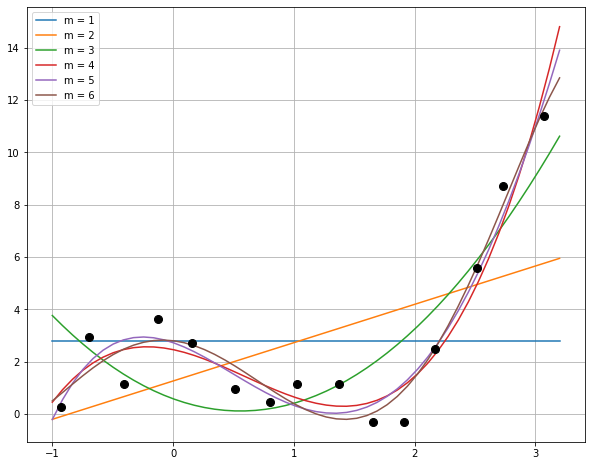

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
for m in range(1, 7):
    p = lsq_poly(x, y, m)
    
    xx = np.linspace(-1, 3.2, 51)
    ax.plot(xx, p(xx), '-', label='m = %s' % m)

ax.plot(x, y, 'o', ms=8, color='k')
plt.legend(loc='best')
plt.grid()

### III. МНК с использованием QR-разложения.

Для оптимального значения $m$ из предыдущей части решите задачу МНК, QR-разложение design матрицы. Для решения задач линейной алгебры можете использовать библиотечные функции (обратите внимание на `scipy.linalg.solve_triangular` и `scipy.linalg.qr` и т.д.) или код предыдущих недель.
Сравните результат с ответом, полученным при решении системы уравнений.

`Least squares via QR:`

$$\xi(\beta) = ||y - A\beta||^2 = ||Q^T(y - A\beta)||^2 = ||Q^Ty - \begin{bmatrix} R_1 \\ 0 \end{bmatrix}\beta||^2$$

$\text{Note that} \ Q^Ty = \begin{bmatrix} f \\ r \end{bmatrix}, \ \text{where} \ dim(f)=m, \ dim(r)=n-m.$

$$\xi(\beta) = ||f - R_1\beta)||^2 + ||r||^2 \rightarrow min, \ \Rightarrow R_1 \beta = f$$

In [12]:
def lsq_qr(x, y, m):
    """Solve the LSQ problem via the QR decomp of the design matrix.

    Parameters
    ----------
    x : array_like
        Sample points
    y : array_like
        Measured values
    m : int
        The degree of the LSQ polynomial
        
    Returns
    -------
    p : callable 
        np.polynomial.Polynomial instance, representing the LSQ polynomial
    
    """
    A = design_matrix(x, m)
    Q, R1 = np.linalg.qr(A, mode='reduced')
    f = (Q.T @ y)[:m]
    coeffs = np.linalg.solve(R1, f)[::-1]
    
    return np.poly1d(coeffs)

In [13]:
from numpy.testing import assert_allclose

for m in range(1, 10):
    assert_allclose(lsq_qr(x, y, m=m).coef,
                    lsq_poly(x, y, m=m).coef,
                    atol=1e-14)

In [14]:
# This cell spot-tests several polynomials to make sure that they are worse than your ``best'' polynomial.

